
Backtesting the strategy with Kalman Filter 
================


Igor Marfin < <igor.marfin@unister.de>>


Abstract
----------------




--------------------------

Here is an example of the backtesting the strategy with a  Kalman Filter.




Initialization
--------------------------


--------------------------

In [3]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline


import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd
import scipy.stats as stats

# use a nice style for plots and the notebook

import json
s = json.load( open("styles/my_matplotlibrc.json") )
matplotlib.rcParams.update(s)

from IPython.core.display import HTML
from IPython.display import display, Math, Latex
import urllib2


def css_styling():
    styles = open("styles/custom_v3.css", "r").read()
    return HTML(styles)
css_styling()

#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )

ion()


# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Kalman Filter


----------------------

In [4]:
class BasicKalmanFilter(object):
    ''' Stochastic Kalman Filter to model 'Close' prices of the stock market '''

    def __init__(self, data,  F_init, G_init, H_init, P_init, x_init,acc_variance=100., obs_variance=100., delta_t = 0.5):
        
        # Specify the model.
        logging.info('building the KalmanFilter model')
        
        # data to be tested
        self.data = data 
        
        # a state transition model: it's stable and doesn't depend on x_k
        self.F = F_init
        
        #  Effect from unknown forces a_k 
        self.G = G_init
        
        #  x is our state vector
        self.x = x_init
        
        #  acc_variance is variance of the unknown forces a_k 
        self.acc_variance = acc_variance
        
        
        #  obs_variance is variance of the measurement of the 'close' price
        self.obs_variance = obs_variance
        
        
        # delta_t is the typical period of the action of the force during the trading day: 
        # delta_t = 0.5 -> means that the force acts on the price during the first half of the trading day.
        self.delta_t = delta_t
        
        
        # a dim. of the hidden state
        self.dim = x_init.shape[0]
        
        
        # a control input: this Kalman Filter is designed w/o use of the control input
        self.B = np.zeros((self.dim,self.dim))
        self.u = np.zeros((self.dim,1))

        # the Q matrix: the covariance matrix of the  state transition model, i.e Q=G^T.G*\sigma_a^2
        # explicitelly , it is 
        #self.Q = np.array([ [self.delta_t**4/4, self.delta_t**3/2], [self.delta_t**3/2, self.delta_t**2]])*self.acc_variance
        self.Q = self.G.T*self.G*self.acc_variance
        
        
        # the H matrix: the observation model 
        self.H = H_init
        
        # Predicted (a priori) estimate covariance
        self.P = P_init
        
        
        # the matrix R is the  covariance of measurement
        self.R = np.array( [[ self.obs_variance]])
        
        logging.info('done building the KalmanFilter model') 
        
    
    def predict(self):
        raise NotImplementedError(
            'KalmanFilter prediction is not implemented ')
    
    def update(self,z):
        raise NotImplementedError(
            'KalmanFilter update is not implemented ')    

    def __str__(self):
        return self.__class__.__name__

In [5]:
# Kalman Filter of the stochastic price process as a function of the time
class KalmanFilter(BasicKalmanFilter):
    pass

Data and Backtester
------------

------------------

I will use an another simple  backtester called `tradingWithPython`. The main difference between 
`tradingWithPython` and `pybacktest` is only control plots. Also I have found that an investment system of 
`tradingWithPython` is more interesting: it allows to invest money and a number or shares you have.
Later, I will return to this tester when I make the portfolio optimization using Mean-Variance technologies.

Ideally, we want to have several instruments to work out on the market. But the question is what the weight of each asset should be in our portfolio.

Got 194 days of data
Got 194 days of data


price  price_open  signal
2015-06-03  540.309998  539.909973     NaN
2015-06-04  536.700012  537.760010     NaN
2015-06-05  533.330017  536.349976     NaN
2015-06-08  526.830017  533.309998     NaN
2015-06-09  526.690002  527.559998     NaN

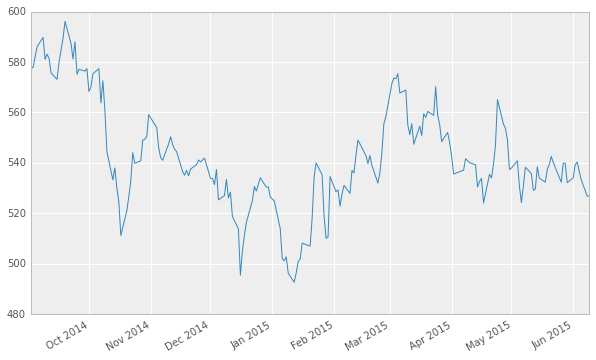

In [128]:
sys.path = [os.getcwd()+'/tradingWithPython-0.0.14.0/'] + sys.path 
sys.path = [os.getcwd()+'/tradingWithPython-0.0.14.0/tradingWithPython'] + sys.path 
sys.path = [os.getcwd()+'/tradingWithPython-0.0.14.0/tradingWithPython/lib'] + sys.path
import tradingWithPython as twp
assert twp.__version__ >= '0.0.12' , 'Please update your twp module '
import tradingWithPython.lib 

from tradingWithPython.lib import yahooFinance

# get data: GOOG prices
price =  yahooFinance.getHistoricData('GOOG',sDate= (2014,9,1))['close']
price_open =  yahooFinance.getHistoricData('GOOG',sDate= (2014,9,1))['open']

price.plot()

# empty so far
signal = pd.Series(index=price.index) # strategy signal, in $

pd.DataFrame({'price':price,'signal':signal,'price_open':price_open}).tail() # show price and signal as a table.

In [129]:
print pd.DataFrame({'price':price,'signal':signal,'price_open':price_open}).head(3) # show price and signal as a table.
print pd.DataFrame({'price':price,'signal':signal,'price_open':price_open.shift()}).head(3) # show price and signal as a table.

                 price  price_open  signal
2014-09-02  577.332662  571.852545     NaN
2014-09-03  577.942611  580.002643     NaN
2014-09-04  581.982621  580.002643     NaN
                 price  price_open  signal
2014-09-02  577.332662         NaN     NaN
2014-09-03  577.942611  571.852545     NaN
2014-09-04  581.982621  580.002643     NaN


Train the Kalman Filter
---------------------------

----------------------

In [36]:
from numpy.linalg import inv
def _predict(kalman_model):
    ''' predicts the price  using kalman_model '''
    
    # the state vector should be of the one-column type
    assert kalman_model.x.shape[1] == 1
    
    # check the consistency of the transition model
    assert kalman_model.F.shape[0] == kalman_model.x.shape[0]
    
    # check the consistency of the control-input model
    assert kalman_model.u.shape == kalman_model.x.shape        
    assert kalman_model.B.shape[0] == kalman_model.u.shape[0]
    
    # check the consistency of the control-input model
    assert kalman_model.F.shape[1] == kalman_model.P.shape[0]
    assert kalman_model.Q.shape == kalman_model.P.shape

    x_p = np.dot(kalman_model.F, kalman_model.x) + np.dot(kalman_model.B,kalman_model.u)
    P_p = np.dot(kalman_model.F,kalman_model.P).dot(kalman_model.F.T) + kalman_model.Q

    assert kalman_model.x.shape == x_p.shape
    assert P_p.shape == kalman_model.P.shape

    return x_p, P_p



def _update(kalman_model,z):
    ''' updates the price  using kalman_model '''
    
    # make a prediction
    x_p, P_p = kalman_model.predict()
    
    assert kalman_model.H.shape[1] == x_p.shape[0]
    assert kalman_model.H.shape[1] == P_p.shape[0]
    assert kalman_model.R.shape[0] == kalman_model.H.shape[0]
    
    # check the consistency of the measured data
    assert z.shape[1] == 1
    assert z.shape[0] == kalman_model.H.shape[0]

    y = z - dot(kalman_model.H,x_p)
    S = np.dot(kalman_model.H,P_p).dot(kalman_model.H.T) + kalman_model.R
    K = np.dot(P_p, kalman_model.H.T).dot(inv(S))
    x_u = x_p + np.dot(K,y)
    P_u = (np.eye(K.shape[0]) - np.dot(K,kalman_model.H)).dot(P_p)

    # save updated parametes of the model
    kalman_model.x = x_u
    kalman_model.P = P_u
    return x_u, P_u

# Update our class with the predict/update infrastructure
KalmanFilter.predict = _predict
KalmanFilter.update = _update

In [38]:
# Test of Kalaman Filter Class


# a transition model: We measure the state each day -> delta_t = 1.
delta_t = 1.
F_init = np.array([[1, delta_t],[0,1]])

# an 'acting-force' model
G_init =  np.array([[delta_t**2/2], [delta_t]])

# an observation model
H_init = np.array([[1,0]])

# an initial state: the price and its velocity
x_init   = np.array([[price[0]],[0.]])



# a priory covariance matrix
# If the initial price and velocity are not known perfectly 
# the covariance matrix should be initialized with a suitably large number, say L, on its diagonal.

P_init = np.array([[1, 0],[0,100.]]) # L=100.

    
kf = KalmanFilter(price[:].as_matrix(),F_init,G_init,H_init,P_init,x_init,acc_variance=1., obs_variance=100.,delta_t =delta_t)


INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


In [37]:
def _get_all_predictions(kalman_model):
    ''' return all predicted prices '''
    
    time_steps = len(kalman_model.data)
    price_guesses = np.zeros((2,time_steps))
    price_predicted = np.zeros((2,time_steps))
    price_actual = np.zeros((2,time_steps))
    
    
    
    for i in range(time_steps):
        x_p, P_p = kalman_model.predict()
        x_g, P_g = kalman_model.update(np.array([[kalman_model.data[i]]]))
    
        
        price_guesses[:,i] = x_g[:,0]
        price_predicted[:,i] = x_p[:,0]
        price_actual[:,i] = np.array([[kalman_model.data[i]],[0.]])[:,0] # Here 0. --> observed velocity :-)
    
    guesses, actual,predicted = price_guesses[0,:], price_actual[0,:], price_predicted[0,:]
    return predicted


# update the definition of the class
KalmanFilter.get_all_predictions = _get_all_predictions

In [40]:
price_predicted = pd.Series(kf.get_all_predictions(),index=price.index) # predicted price
price_predicted.tail()

2015-06-03    536.947587
2015-06-04    538.391801
2015-06-05    537.881160
2015-06-08    535.977060
2015-06-09    531.686673
dtype: float64

Let's define our strategy

In [202]:
strategy = pd.DataFrame({'price':price,'signal':signal,'predicted':price_predicted})

In [203]:
buy =  (strategy.price > strategy.predicted) & (strategy.price .shift() < strategy.predicted.shift())  #  cross up
sell = (strategy.price  < strategy.predicted) & (strategy.price .shift() > strategy.predicted.shift())  #  cross down

In [204]:
strategy['buy'] = buy
strategy['sel'] = sell

# use 1000 as the number which should be larger the price of the stock share
#strategy['signal'] = strategy.apply(lambda x:  1000 if x['buy'] else (-1000  if  x['sel'] else np.nan) ,axis=1)
strategy['signal'] = strategy.apply(lambda x:  2000 if x['buy'] else (-2000  if  x['sel'] else np.nan) ,axis=1)

# to be more realistic: if we start with short operation we need to have shares let's buy them
# and it is better to come in the position in some trend :-)
strategy['signal'][2] = 2000
strategy['signal'][3] = 0

# close the position
strategy['signal'][-1]  = 0
strategy.head()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


predicted       price  signal    buy    sel
2014-09-02  528.490686  577.332662     NaN  False  False
2014-09-03  548.583970  577.942611     NaN  False  False
2014-09-04  564.011945  581.982621    2000  False  False
2014-09-05  576.777906  586.082672       0  False  False
2014-09-08  587.168521  589.722659     NaN  False  False

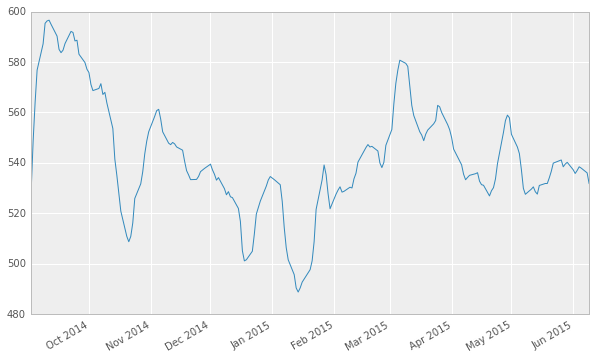

In [123]:
strategy.predicted.plot()

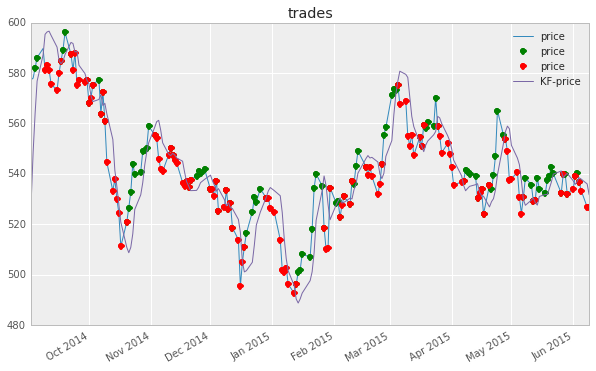

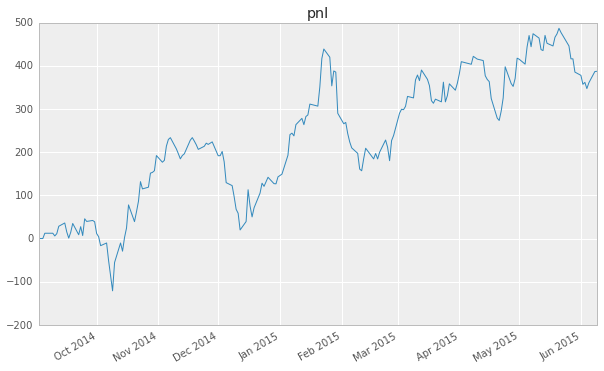

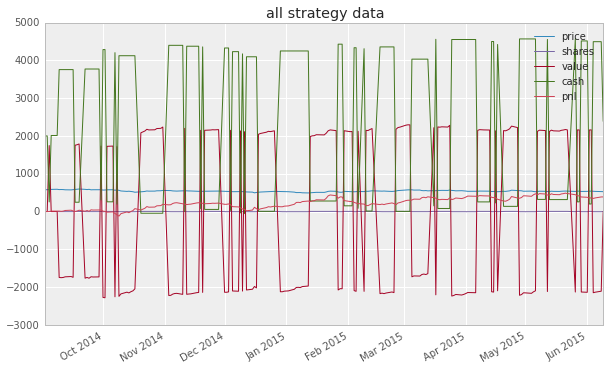

In [156]:
figsize(10,6)

bt = twp.Backtest(strategy.price,strategy.signal,initialCash=2000)
bt.plotTrades()
strategy.predicted.plot(label='KF-price')
legend(loc='upper right')

figure()
bt.pnl.plot()
title('pnl')

figure()
bt.data.plot()
title('all strategy data')

In [157]:
# normally, daily change in shares (delta) is not included in the Backtest.data .
# Sometimes it is handy to have it, for adding transaction cost for example. 
# You can easily add it :
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

bt.data # output strategy data

price  shares        value         cash         pnl  delta
2014-09-02  577.332662       0     0.000000  2000.000000    0.000000      0
2014-09-03  577.942611       0     0.000000  2000.000000    0.000000      0
2014-09-04  581.982621       3  1745.947863   254.052137    0.000000      3
2014-09-05  586.082672       0     0.000000  2012.300153   12.300153     -3
2014-09-08  589.722659       0     0.000000  2012.300153   12.300153      0
2014-09-09  581.012615      -3 -1743.037845  3755.337998   12.300153     -3
2014-09-10  583.102636      -3 -1749.307908  3755.337998    6.030090      0
2014-09-11  581.352598      -3 -1744.057794  3755.337998   11.280204      0
2014-09-12  575.622589      -3 -1726.867767  3755.337998   28.470231      0
2014-09-15  573.102555      -3 -1719.307665  3755.337998   36.030333      0
2014-09-16  579.952640      -3 -1739.857920  3755.337998   15.480078      0
2014-09-17  584.772683       3  1754.318049   246.701900    1.019949      6
2014-09-18  589.272695       3  1767.818085   246.701900   14.519985      0
2014-09-19  596.082692       3  1788.248076   246.701900   34.949976      0
2014-09-22  587.372648      -3 -1762.117944  3770.937788    8.819844     -6
2014-09-23  581.132634      -3 -1743.397902  3770.937788   27.539886      0
2014-09-24  587.992634      -3 -1763.977902  3770.937788    6.959886      0
2014-09-25  575.062581      -3 -1725.187743  3770.937788   45.750045      0
2014-09-26  577.102600      -3 -1731.307800  3770.937788   39.629988      0
2014-09-29  576.362594      -3 -1729.087782  3770.937788   41.850006      0
2014-09-30  577.362590       3  1732.087770   306.762248   38.850018      6
2014-10-01  568.272597      -4 -2273.090388  4284.670427   11.580039     -7
2014-10-02  570.082615      -4 -2280.330460  4284.670427    4.339967      0
2014-10-03  575.282606       3  1725.847818   257.692185  -16.459997      7
2014-10-06  577.352614       3  1732.057842   257.692185  -10.249973      0
2014-10-07  563.742534      -4 -2254.970136  4203.889923  -51.080213     -7
2014-10-08  572.502582       3  1717.507746   196.371849  -86.120405      7
2014-10-09  560.882579      -4 -2243.530316  4122.549902 -120.980414     -7
2014-10-10  544.492476      -4 -2177.969904  4122.549902  -55.420002      0
2014-10-13  533.212456      -4 -2132.849824  4122.549902  -10.299922      0
...                ...     ...          ...          ...         ...    ...
2015-04-28  553.679993      -4 -2214.719972  4566.870922  352.150950     -8
2015-04-29  549.080017      -4 -2196.320068  4566.870922  370.550854      0
2015-04-30  537.340027      -4 -2149.360108  4566.870922  417.510814      0
2015-05-01  537.900024      -4 -2151.600096  4566.870922  415.270826      0
2015-05-04  540.780029      -4 -2163.120116  4566.870922  403.750806      0
2015-05-05  530.799988      -4 -2123.199952  4566.870922  443.670970      0
2015-05-06  524.219971      -4 -2096.879884  4566.870922  469.991038      0
2015-05-07  530.700012       4  2122.800048   321.270826  444.070874      8
2015-05-08  538.219971       4  2152.879884   321.270826  474.150710      0
2015-05-11  535.700012       4  2142.800048   321.270826  464.070874      0
2015-05-12  529.039978      -4 -2116.159912  4553.590650  437.430738     -8
2015-05-13  529.619995       4  2118.479980   316.630690  435.110670      8
2015-05-14  538.400024       4  2153.600096   316.630690  470.230786      0
2015-05-15  533.849976       4  2135.399904   316.630690  452.030594      0
2015-05-18  532.299988       4  2129.199952   316.630690  445.830642      0
2015-05-19  537.359985       4  2149.439940   316.630690  466.070630      0
2015-05-20  539.270020       4  2157.080080   316.630690  473.710770      0
2015-05-21  542.510010       4  2170.040040   316.630690  486.670730      0
2015-05-22  540.109985       4  2160.439940   316.630690  477.070630      0
2015-05-26  532.320007      -4 -2129.280028  4575.190746  445.910718     -8
2015-05-27  539.789978       4  2159.159912   256.870922  416.030

This simple strategy gives 

In [147]:
(bt.data.index[-1]-bt.data.index[0],(bt.data['cash'][-1]-2000.)/2000.)


(Timedelta('280 days 00:00:00'), 0.19357547299999964)

.i.e 19.3% for 280 days. That's not bad.

Optimization of the strategy
-----------------------------------


--------------------

It's clear that there is sometimes some time shift between between making the decision on the position and 

applying to the real life in our strategy. 

In [131]:
print pd.DataFrame({'price':price,'signal':signal,'price_open':price_open}).head(3) # show price and signal as a table.
print pd.DataFrame({'price':price,'signal':signal,'price_open':price_open.shift(-1)}).head(3) # show price and signal as a table.

                 price  price_open  signal
2014-09-02  577.332662  571.852545     NaN
2014-09-03  577.942611  580.002643     NaN
2014-09-04  581.982621  580.002643     NaN
                 price  price_open  signal
2014-09-02  577.332662  580.002643     NaN
2014-09-03  577.942611  580.002643     NaN
2014-09-04  581.982621  583.982613     NaN


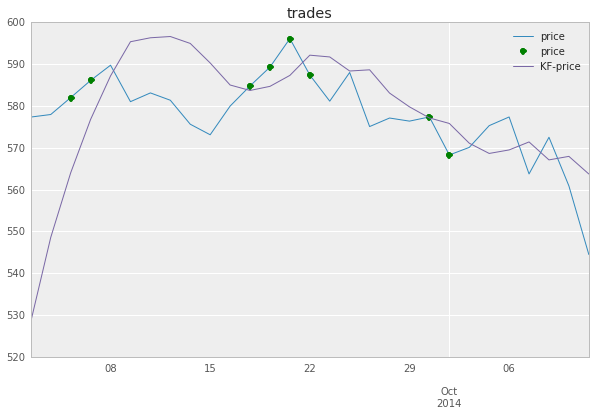

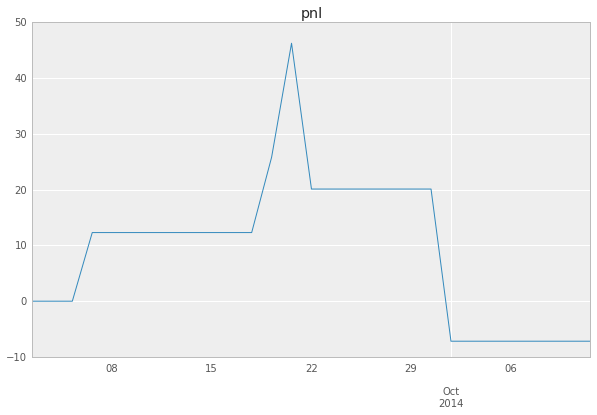

In [198]:
# analyse the problematic place of our strategy

bt.data = bt.data['2014-9-1':'2014-10-10']
bt.plotTrades()
strategy['2014-9-1':'2014-10-10'].predicted.plot(label='KF-price')
legend(loc='upper right')

figure()
bt.pnl.plot()
title('pnl')


In [199]:
strategy2 = strategy['2014-9-1':'2014-10-10']
strategy2['signal'] = np.array([ strategy2['signal'].as_matrix()[i] if np.isnan(strategy2['signal'].as_matrix()[i]) else strategy2['signal'].as_matrix()[i] if i<2 else 0 if (  not np.isnan(strategy2['signal'].as_matrix()[i-1]) or not np.isnan(strategy2['signal'].as_matrix()[i-2])) else strategy2['signal'].as_matrix()[i] for i in range(len(strategy2['signal']))])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [200]:
strategy2['2014-9-1':'2014-10-10']


predicted       price  signal    buy    sel
2014-09-02  528.490686  577.332662     NaN  False  False
2014-09-03  548.583970  577.942611     NaN  False  False
2014-09-04  564.011945  581.982621    2000  False  False
2014-09-05  576.777906  586.082672       0  False  False
2014-09-08  587.168521  589.722659     NaN  False  False
2014-09-09  595.333241  581.012615       0  False   True
2014-09-10  596.277396  583.102636     NaN  False  False
2014-09-11  596.580082  581.352598     NaN  False  False
2014-09-12  594.925588  575.622589     NaN  False  False
2014-09-15  590.259669  573.102555     NaN  False  False
2014-09-16  584.993700  579.952640     NaN  False  False
2014-09-17  583.686225  584.772683    2000   True  False
2014-09-18  584.671573  589.272695     NaN  False  False
2014-09-19  587.290290  596.082692     NaN  False  False
2014-09-22  592.121260  587.372648       0  False   True
2014-09-23  591.697576  581.132634     NaN  False  False
2014-09-24  588.334818  587.992634     NaN  False  False
2014-09-25  588.624878  575.062581     NaN  False  False
2014-09-26  583.070714  577.102600     NaN  False  False
2014-09-29  579.773006  576.362594     NaN  False  False
2014-09-30  577.123238  577.362590    2000   True  False
2014-10-01  575.806533  568.272597       0  False   True
2014-10-02  571.088730  570.082615     NaN  False  False
2014-10-03  568.640453  575.282606       0   True  False
2014-10-06  569.476925  577.352614     NaN  False  False
2014-10-07  571.387525  563.742534       0  False   True
2014-10-08  567.099081  572.502582       0   True  False
2014-10-09  567.940374  560.882579       0  False   True
2014-10-10  563.730977  544.492476     NaN  False  False

In [163]:
bt.data

price  shares        value         cash         pnl  delta
2014-09-02  577.332662       0     0.000000  2000.000000    0.000000      0
2014-09-03  577.942611       0     0.000000  2000.000000    0.000000      0
2014-09-04  581.982621       3  1745.947863   254.052137    0.000000      3
2014-09-05  586.082672       0     0.000000  2012.300153   12.300153     -3
2014-09-08  589.722659       0     0.000000  2012.300153   12.300153      0
2014-09-09  581.012615      -3 -1743.037845  3755.337998   12.300153     -3
2014-09-10  583.102636      -3 -1749.307908  3755.337998    6.030090      0
2014-09-11  581.352598      -3 -1744.057794  3755.337998   11.280204      0
2014-09-12  575.622589      -3 -1726.867767  3755.337998   28.470231      0
2014-09-15  573.102555      -3 -1719.307665  3755.337998   36.030333      0
2014-09-16  579.952640      -3 -1739.857920  3755.337998   15.480078      0
2014-09-17  584.772683       3  1754.318049   246.701900    1.019949      6
2014-09-18  589.272695       3  1767.818085   246.701900   14.519985      0
2014-09-19  596.082692       3  1788.248076   246.701900   34.949976      0
2014-09-22  587.372648      -3 -1762.117944  3770.937788    8.819844     -6
2014-09-23  581.132634      -3 -1743.397902  3770.937788   27.539886      0
2014-09-24  587.992634      -3 -1763.977902  3770.937788    6.959886      0
2014-09-25  575.062581      -3 -1725.187743  3770.937788   45.750045      0
2014-09-26  577.102600      -3 -1731.307800  3770.937788   39.629988      0
2014-09-29  576.362594      -3 -1729.087782  3770.937788   41.850006      0
2014-09-30  577.362590       3  1732.087770   306.762248   38.850018      6
2014-10-01  568.272597      -4 -2273.090388  4284.670427   11.580039     -7
2014-10-02  570.082615      -4 -2280.330460  4284.670427    4.339967      0
2014-10-03  575.282606       3  1725.847818   257.692185  -16.459997      7
2014-10-06  577.352614       3  1732.057842   257.692185  -10.249973      0
2014-10-07  563.742534      -4 -2254.970136  4203.889923  -51.080213     -7
2014-10-08  572.502582       3  1717.507746   196.371849  -86.120405      7
2014-10-09  560.882579      -4 -2243.530316  4122.549902 -120.980414     -7
2014-10-10  544.492476      -4 -2177.969904  4122.549902  -55.420002      0

This is the optimization of the algorithm: close all positions which were open 'close' to the previous ones:

In [183]:
strategy2 = strategy['2014-9-1':'2014-10-10']
strategy2['signal'] = np.array([ strategy2['signal'].as_matrix()[i] if np.isnan(strategy2['signal'].as_matrix()[i]) else strategy2['signal'].as_matrix()[i] if i<2 else 0 if (  not np.isnan(strategy2['signal'].as_matrix()[i-1]) or not np.isnan(strategy2['signal'].as_matrix()[i-2])) else strategy2['signal'].as_matrix()[i] for i in range(len(strategy2['signal']))])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [205]:
strategy['signal'] = np.array([ strategy['signal'].as_matrix()[i] if np.isnan(strategy['signal'].as_matrix()[i]) else strategy['signal'].as_matrix()[i] if i<3 else 0 if (  not np.isnan(strategy['signal'].as_matrix()[i-1]) or not np.isnan(strategy['signal'].as_matrix()[i-2]) or not np.isnan(strategy['signal'].as_matrix()[i-3])) else strategy['signal'].as_matrix()[i] for i in range(len(strategy['signal']))])

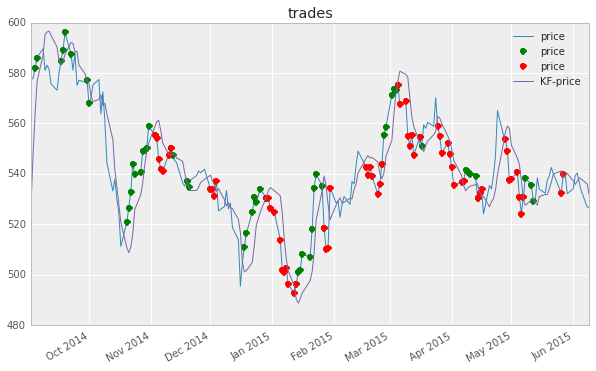

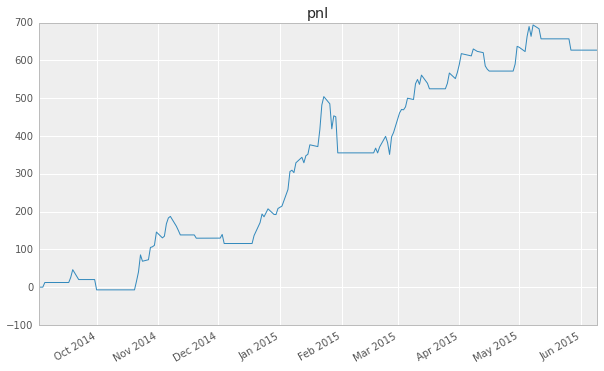

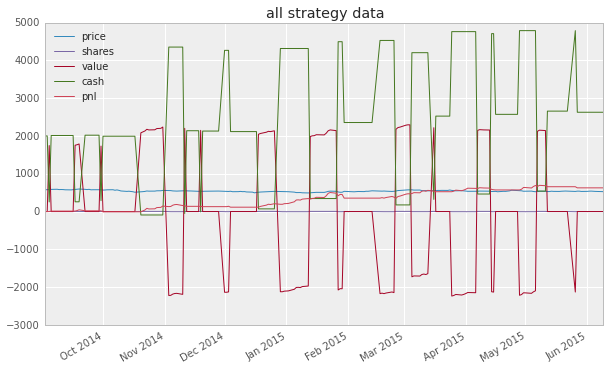

In [206]:
figsize(10,6)

bt = twp.Backtest(strategy.price,strategy.signal,initialCash=2000)
bt.plotTrades()
strategy.predicted.plot(label='KF-price')
legend(loc='upper right')

figure()
bt.pnl.plot()
title('pnl')

figure()
bt.data.plot()
title('all strategy data')

In [207]:
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

bt.data # output strategy data


price  shares        value         cash         pnl  delta
2014-09-02  577.332662       0     0.000000  2000.000000    0.000000      0
2014-09-03  577.942611       0     0.000000  2000.000000    0.000000      0
2014-09-04  581.982621       3  1745.947863   254.052137    0.000000      3
2014-09-05  586.082672       0     0.000000  2012.300153   12.300153     -3
2014-09-08  589.722659       0     0.000000  2012.300153   12.300153      0
2014-09-09  581.012615       0     0.000000  2012.300153   12.300153      0
2014-09-10  583.102636       0     0.000000  2012.300153   12.300153      0
2014-09-11  581.352598       0     0.000000  2012.300153   12.300153      0
2014-09-12  575.622589       0     0.000000  2012.300153   12.300153      0
2014-09-15  573.102555       0     0.000000  2012.300153   12.300153      0
2014-09-16  579.952640       0     0.000000  2012.300153   12.300153      0
2014-09-17  584.772683       3  1754.318049   257.982104   12.300153      3
2014-09-18  589.272695       3  1767.818085   257.982104   25.800189      0
2014-09-19  596.082692       3  1788.248076   257.982104   46.230180      0
2014-09-22  587.372648       0     0.000000  2020.100048   20.100048     -3
2014-09-23  581.132634       0     0.000000  2020.100048   20.100048      0
2014-09-24  587.992634       0     0.000000  2020.100048   20.100048      0
2014-09-25  575.062581       0     0.000000  2020.100048   20.100048      0
2014-09-26  577.102600       0     0.000000  2020.100048   20.100048      0
2014-09-29  576.362594       0     0.000000  2020.100048   20.100048      0
2014-09-30  577.362590       3  1732.087770   288.012278   20.100048      3
2014-10-01  568.272597       0     0.000000  1992.830069   -7.169931     -3
2014-10-02  570.082615       0     0.000000  1992.830069   -7.169931      0
2014-10-03  575.282606       0     0.000000  1992.830069   -7.169931      0
2014-10-06  577.352614       0     0.000000  1992.830069   -7.169931      0
2014-10-07  563.742534       0     0.000000  1992.830069   -7.169931      0
2014-10-08  572.502582       0     0.000000  1992.830069   -7.169931      0
2014-10-09  560.882579       0     0.000000  1992.830069   -7.169931      0
2014-10-10  544.492476       0     0.000000  1992.830069   -7.169931      0
2014-10-13  533.212456       0     0.000000  1992.830069   -7.169931      0
...                ...     ...          ...          ...         ...    ...
2015-04-28  553.679993      -4 -2214.719972  4786.352433  571.632461     -4
2015-04-29  549.080017      -4 -2196.320068  4786.352433  590.032365      0
2015-04-30  537.340027      -4 -2149.360108  4786.352433  636.992325      0
2015-05-01  537.900024      -4 -2151.600096  4786.352433  634.752337      0
2015-05-04  540.780029      -4 -2163.120116  4786.352433  623.232317      0
2015-05-05  530.799988      -4 -2123.199952  4786.352433  663.152481      0
2015-05-06  524.219971      -4 -2096.879884  4786.352433  689.472549      0
2015-05-07  530.700012       4  2122.800048   540.752337  663.552385      8
2015-05-08  538.219971       4  2152.879884   540.752337  693.632221      0
2015-05-11  535.700012       4  2142.800048   540.752337  683.552385      0
2015-05-12  529.039978       0     0.000000  2656.912249  656.912249     -4
2015-05-13  529.619995       0     0.000000  2656.912249  656.912249      0
2015-05-14  538.400024       0     0.000000  2656.912249  656.912249      0
2015-05-15  533.849976       0     0.000000  2656.912249  656.912249      0
2015-05-18  532.299988       0     0.000000  2656.912249  656.912249      0
2015-05-19  537.359985       0     0.000000  2656.912249  656.912249      0
2015-05-20  539.270020       0     0.000000  2656.912249  656.912249      0
2015-05-21  542.510010       0     0.000000  2656.912249  656.912249      0
2015-05-22  540.109985       0     0.000000  2656.912249  656.912249      0
2015-05-26  532.320007      -4 -2129.280028  4786.192277  656.912249     -4
2015-05-27  539.789978       0     0.000000  2627.032365  627.032

In [208]:
(bt.data.index[-1]-bt.data.index[0],(bt.data['cash'][-1]-2000.)/2000.)

(Timedelta('280 days 00:00:00'), 0.31351618250000024)

.i.e the optimization gets  11%=31.3-19.3% of the profit to us. :-)